In [158]:
import pandas as pd
import numpy as np 
from scipy import stats

# data visualization packages 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
pd.set_option('max_columns', None)

#machine learning packages
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV, RFE
from imblearn.over_sampling import SMOTE 
from sklearn.utils import resample
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')
np.random.seed(123)

# Load the Data

In [273]:
# Load DF

df = pd.read_csv('./data/diabetic_data.csv', na_values='?')

In [274]:
# Shape of dataframe

df.shape

(101766, 50)

In [275]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [276]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

# Cleaning - Missingness

([<matplotlib.axis.YTick at 0x1d63adacc70>,
 [Text(0, 0, 'Weight'),
  Text(0, 0, 'Medical Specialty'),
  Text(0, 0, 'Payer Code'),
  Text(0, 0, 'Race'),
  Text(0, 0, 'Diagnostic 3')])

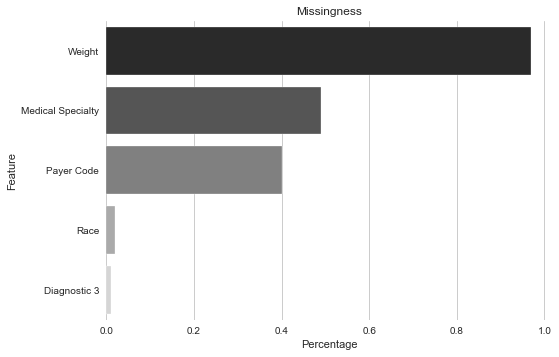

In [277]:
# Compute missingness 
missing = round((df.isna().sum()/len(df)),2).sort_values(ascending = True)
missing = missing[missing > 0]

# Missing values table 
missing_table = pd.DataFrame(data=missing)
missing_table = missing_table.reset_index()
missing_table.columns = ['Feature', 'Percentage']
missing_table.sort_values(by="Percentage", inplace = True, ascending = False)
missing_table.style.hide_index()

plt.figure()
sns.barplot(x="Percentage", y = "Feature", data = missing_table , ci = 95, palette = 'binary_r')
sns.set_style(style="whitegrid")
plt.title('Missingness')
plt.xlabel('Percentage')
plt.ylabel('Feature')
plt.yticks(np.arange(5), ('Weight','Medical Specialty','Payer Code','Race','Diagnostic 3'))

In [278]:
# Missing values table 

missing_table = pd.DataFrame(data=missing)
missing_table = missing_table.reset_index()
missing_table.columns = ['Feature', 'Percentage']
missing_table.sort_values(by="Percentage", inplace = True, ascending = False)
missing_table.style.hide_index()

Feature,Percentage
weight,0.970000
medical_specialty,0.490000
payer_code,0.400000
race,0.020000
diag_3,0.010000


In [279]:
# Create target column
#Set all values <30 to YES (Readmission), else all other values to NO

df.readmitted = df.readmitted.apply(lambda x: 'Yes' if x in ['<30'] else 'No')

In [280]:
# Drop columns for missingness

df = df.drop(columns="weight")
df = df.drop(columns="payer_code")
df = df.drop(columns="medical_specialty")

In [167]:
# Dealing with Missingness

df = df.replace("?",np.NaN)
df.race = df.race.replace(np.NaN,"unknown")
df = df.replace(np.NaN, "missing")

In [168]:
df.isna().sum().sum()

0

# Cleaning - Delete Multiple Encounters

In [169]:
# Drop duplicate values for patient number. Keep first entry to show if patient was readmitted or not.

df = df.drop_duplicates('patient_nbr', keep = 'first')
df = df.drop(columns="encounter_id")
df = df.drop(columns="patient_nbr")

# Dropping Features

In [170]:
# No patients take these medications

df = df.drop(columns = ["examide", "citoglipton"])

# EDA/Feature Engineering

In [171]:
# Preliminary data split to view the training data only for visualization/EDA
# Note: changes applied to the full data set; training only used for graphical and tabular EDA at this time
X = df.drop('readmitted', axis = 1)
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)

In [172]:
train = X_train.assign(readmitted = y_train)

In [173]:
train

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
69049,Caucasian,Male,[70-80),3,1,7,5,51,3,28,0,0,0,574,574,250,8,None,>8,Steady,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,No
34762,unknown,Male,[60-70),2,1,1,3,33,0,4,0,0,0,250.6,434,305,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
99539,Caucasian,Male,[70-80),1,1,7,5,51,0,13,0,0,0,780,852,8,9,None,Norm,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,No
16325,Caucasian,Female,[60-70),3,18,1,4,19,4,24,0,0,0,722,401,250,4,None,None,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No
14015,unknown,Male,[50-60),2,1,4,2,19,5,7,0,0,0,410,414,250,4,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27584,Caucasian,Female,[80-90),1,1,6,3,43,0,11,0,0,0,428,287,250,5,None,>7,No,No,No,No,No,No,Up,No,No,No,Steady,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,No
17856,Caucasian,Female,[20-30),1,1,7,3,64,0,4,0,0,1,250.11,V15,401,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,Yes
55318,Caucasian,Female,[70-80),1,6,7,9,63,1,34,1,0,0,821,427,428,9,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No
75149,Caucasian,Female,[80-90),2,6,1,2,5,2,6,2,1,0,171,401,250,4,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No


### EDA: A1c

In [283]:
A1c_percent = train[['A1Cresult','readmitted', 'race']].groupby(['A1Cresult','readmitted']).count().apply(lambda x: x/train.race.count())
A1c_percent = A1c_percent.reset_index()
A1c_percent.columns = ['A1Cresult', 'readmitted', 'Percentage']

Text(0, 0.5, 'Percentage')

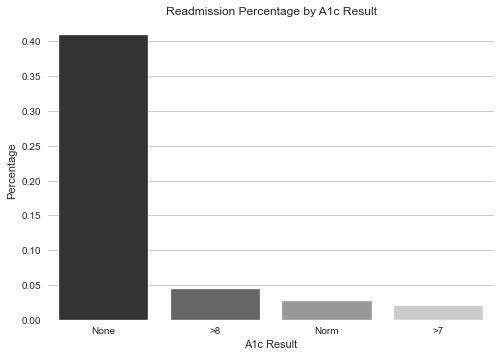

In [286]:
A1c_percent = A1c_percent.sort_values(by = 'Percentage', ascending = False)
plt.figure()
sns.barplot(x="A1Cresult", y = 'Percentage', data = A1c_percent, ci = None, palette = 'binary_r')
sns.set_style(style="whitegrid")
plt.title('Readmission Percentage by A1c Result')
plt.xlabel('A1c Result')
plt.ylabel('Percentage')

### EDA: Max Glucose Serum

Text(0, 0.5, 'Percentage')

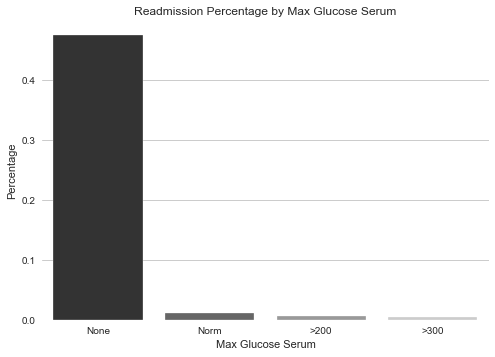

In [289]:
mgs_percent = train[['max_glu_serum','readmitted', 'race']].groupby(['max_glu_serum','readmitted']).count().apply(lambda x: x/train.race.count())
mgs_percent = mgs_percent.reset_index()
mgs_percent.columns = ['max_glu_serum', 'readmitted', 'Percentage']

mgs_percent = mgs_percent.sort_values(by = 'Percentage', ascending = False)
plt.figure()
sns.barplot(x="max_glu_serum", y = 'Percentage', data = mgs_percent, ci = None, palette = 'binary_r')
sns.set_style(style="whitegrid")
plt.title('Readmission Percentage by Max Glucose Serum')
plt.xlabel('Max Glucose Serum')
plt.ylabel('Percentage')

### FE: Medication

In [174]:
insulin_percent = train[['insulin','readmitted', 'race']].groupby(['insulin','readmitted']).count().apply(lambda x: x/train.race.count())
insulin_percent = insulin_percent.reset_index()
insulin_percent.columns = ['insulin', 'readmitted', 'Percentage']

Text(0, 0.5, 'Percentage')

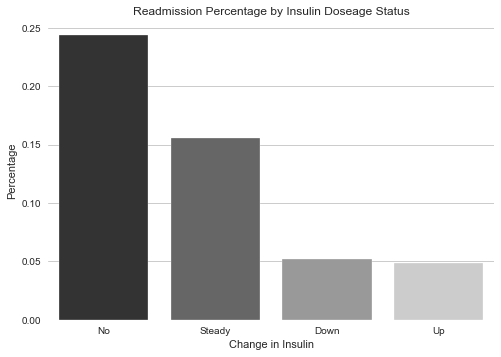

In [175]:
insulin_percent = insulin_percent.sort_values(by = 'Percentage', ascending = False)
plt.figure()
sns.barplot(x="insulin", y = 'Percentage', data = insulin_percent, ci = None, palette = 'binary_r')
sns.set_style(style="whitegrid")
plt.title('Readmission Percentage by Insulin Doseage Status')
plt.xlabel('Change in Insulin')
plt.ylabel('Percentage')

In [176]:
aceto_percent = train[['acetohexamide','readmitted', 'race']].groupby(['acetohexamide','readmitted']).count().apply(lambda x: x/train.race.count())
aceto_percent = aceto_percent.reset_index()
aceto_percent.columns = ['acetohexamide', 'readmitted', 'Percentage']

Text(0, 0.5, 'Percentage')

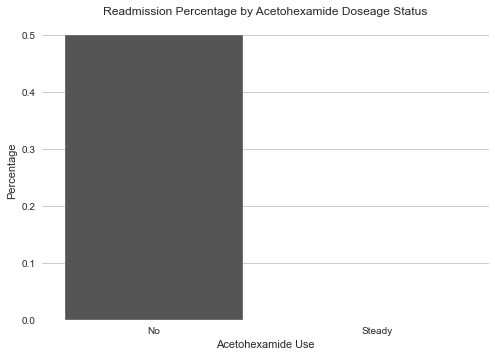

In [282]:
aceto_percent = aceto_percent.sort_values(by = 'Percentage', ascending = False)
plt.figure()
sns.barplot(x='acetohexamide', y = 'Percentage', data = aceto_percent, ci = None, palette = 'binary_r')
sns.set_style(style="whitegrid")
plt.title('Readmission Percentage by Acetohexamide Doseage Status')
plt.xlabel('Acetohexamide Use')
plt.ylabel('Percentage')

### FE: Admission Type ID

In [178]:
adtyp_percent = train[['admission_type_id','readmitted', 'race']].groupby(['admission_type_id','readmitted']).count().apply(lambda x: x/train.race.count())
adtyp_percent = adtyp_percent.reset_index()
adtyp_percent.columns = ['admission_type_id', 'readmitted', 'Percentage']

([<matplotlib.axis.XTick at 0x1d65bea7280>,
 [Text(0, 0, 'Emergency'),
  Text(0, 0, 'Urgent'),
  Text(0, 0, 'Elective'),
  Text(0, 0, 'Newborn'),
  Text(0, 0, 'NA'),
  Text(0, 0, 'NULL'),
  Text(0, 0, 'Trauma'),
  Text(0, 0, 'Not Mapped')])

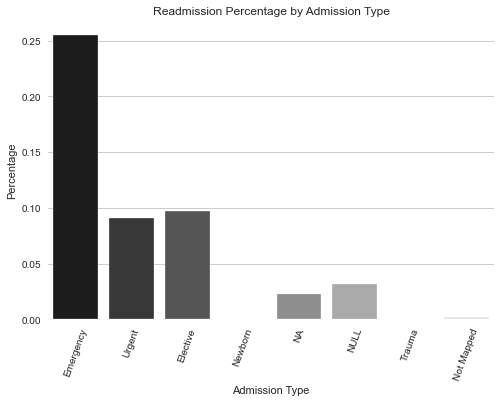

In [179]:
adtyp_percent=adtyp_percent.sort_values(by = 'Percentage', ascending = False)
plt.figure()
sns.barplot(x="admission_type_id", y="Percentage", data=adtyp_percent, ci=None, palette = 'binary_r')
sns.set_style(style="whitegrid")
plt.title('Readmission Percentage by Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('Percentage')
plt.xticks(np.arange(8), ('Emergency','Urgent','Elective', 'Newborn', 'NA', 'NULL', 'Trauma', 'Not Mapped'), rotation=70)

In [180]:
# Group admission type by Emergency, Urgent, Elective, and Other

def modadtype(series):
    
    def newcat(x):
        if x == 1: return "Emergency"
        elif x == 2: return "Urgent"
        elif x == 3: return "Elective"
        else: return "Other"
        
    return series.apply(newcat)

df.admission_type_id = modadtype(df.admission_type_id)

### FE: Admission Source ID

In [181]:
adsour_percent = train[['admission_source_id','readmitted', 'race']].groupby(['admission_source_id','readmitted']).count().apply(lambda x: x/train.race.count())
adsour_percent = adsour_percent.reset_index()
adsour_percent.columns = ['admission_source_id', 'readmitted', 'Percentage']

Text(0, 0.5, 'Percentage')

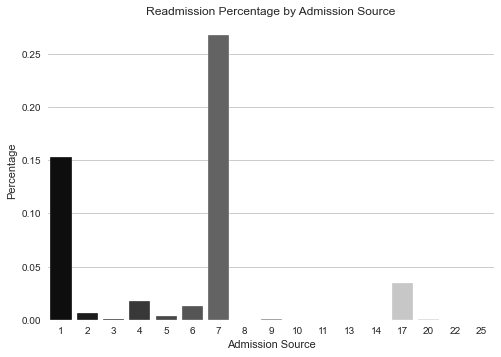

In [182]:
adsour_percent=adsour_percent.sort_values(by = 'Percentage', ascending = False)
adsour_percent
plt.figure()
sns.barplot(x="admission_source_id", y="Percentage", data=adsour_percent, ci=None, palette = 'binary_r')
sns.set_style(style="whitegrid")
plt.title('Readmission Percentage by Admission Source')
plt.xlabel('Admission Source')
plt.ylabel('Percentage')

In [183]:
# Group admission source by Referral, Emergency, and Other

def modadsourc(series):
    
    def newcat(x):
        if x == 1: return "Physician Referral"
        elif x == 7: return "Emergency"
        else: return "Other"
        
    return series.apply(newcat)

df.admission_source_id = modadsourc(df.admission_source_id)

### FE: Discharge Disposition ID

Text(0, 0.5, 'Percentage')

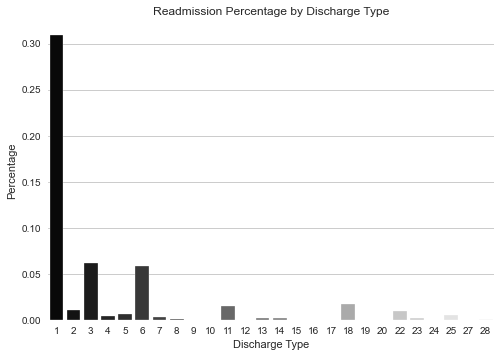

In [184]:

dis_percent = train[['discharge_disposition_id','readmitted', 'race']].groupby(['discharge_disposition_id','readmitted']).count().apply(lambda x: x/train.race.count())
dis_percent = dis_percent.reset_index()
dis_percent.columns = ['discharge_disposition_id', 'readmitted', 'Percentage']

plt.figure()
sns.barplot(x="discharge_disposition_id", y="Percentage", data=dis_percent, ci=None, palette = 'binary_r')
sns.set_style(style="whitegrid")
plt.title('Readmission Percentage by Discharge Type')
plt.xlabel('Discharge Type')
plt.ylabel('Percentage')

In [185]:
## Group discharge dispo by Home or Not_Home discharge

def moddisch(series):
    
    def home(x):
        if x == 1: return "Home"
        else: return "Not_Home"
    
    return series.apply(home)

df.discharge_disposition_id = moddisch(df.discharge_disposition_id)

### FE: Age

In [186]:
# Readmission percentage by age

age_percent = train[['age','readmitted', 'race']].groupby(['age','readmitted']).count().apply(lambda x: x/train.race.count())
age_percent = age_percent.reset_index()
age_percent.columns = ['Age', 'readmitted', 'Percentage']

Text(0, 0.5, 'Percentage')

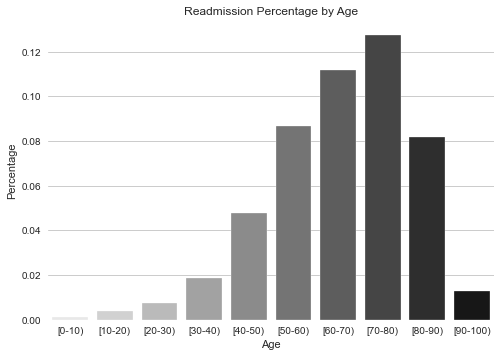

In [187]:
plt.figure()
sns.barplot(x="Age", y="Percentage", data=age_percent , ci=None, palette = 'binary')
sns.set_style(style="whitegrid")
plt.title('Readmission Percentage by Age')
plt.xlabel('Age')
plt.ylabel('Percentage')


In [188]:
# Group age by similar readmission rates: 0-40, 40-90, 90-100

age_id = {'[0-10)':'0-40', 
          '[10-20)':'0-40', 
          '[20-30)':'0-40', 
          '[30-40)':'0-40', 
          '[40-50)':'40-90', 
          '[50-60)':'40-90',
          '[60-70)':'40-90', 
          '[70-80)':'40-90', 
          '[80-90)':'40-90', 
          '[90-100)':'90-100'}

df['age'] = df.age.replace(age_id)

### FE: Race

In [189]:
race_percent = train[['race','readmitted', 'age']].groupby(['race','readmitted']).count().apply(lambda x: x/train.race.count())
race_percent = race_percent.reset_index()
race_percent.columns = ['race', 'readmitted', 'Percentage']

Text(0, 0.5, 'Percentage')

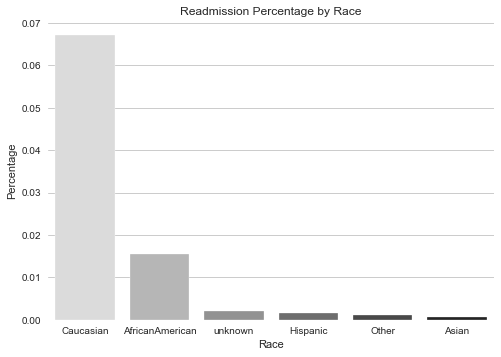

In [190]:
# Graph readmission percentage by race

race_percent = race_percent.sort_values(by = 'Percentage', ascending=False)
plt.figure()
sns.barplot(x="race", y= race_percent.loc[race_percent['readmitted'] == 'Yes', 'Percentage'], data=race_percent, ci= None, palette = 'binary')
sns.set_style(style="whitegrid")
plt.title('Readmission Percentage by Race')
plt.xlabel('Race')
plt.ylabel('Percentage')

In [191]:
# Group race by similar readmission rates, preserving the top two categories: Caucasian and African American

race_id = {'Caucasian':'Caucasian', 
          'AfricanAmerican':'AfricanAmerican', 
          'Other':'Other', 
          'Asian':'Other', 
          'Hispanic':'Other', 
          'unknown':'Missing',}

df['race'] = df.race.replace(race_id)

### FE: Gender

In [192]:
# Show readmission percentage by gender

gender_percent = train[['gender','readmitted', 'race']].groupby(['gender','readmitted']).count().apply(lambda x: x/train.race.count())
gender_percent = gender_percent.reset_index()
gender_percent.columns = ['gender', 'readmitted', 'Percentage']
gender_percent

,gender,readmitted,Percentage
0,Female,No,0.484549
1,Female,Yes,0.047541
2,Male,No,0.427430
3,Male,Yes,0.040445
4,Unknown/Invalid,No,0.000035


Text(0, 0.5, 'Percentage')

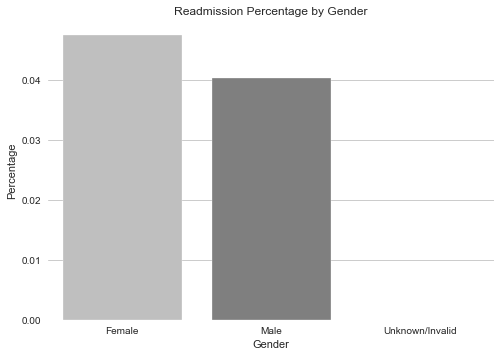

In [193]:
# Graph readmission percentage by gender

plt.figure()
sns.barplot(x="gender", y= gender_percent.loc[gender_percent['readmitted'] == 'Yes', 'Percentage'], data=gender_percent , ci= None, palette = 'binary')
sns.set_style(style="whitegrid")
plt.title('Readmission Percentage by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')

In [194]:
# Inspect Unknown/Invalid results for Gender

df[df['gender'].str.contains('Unknown/Invalid')]

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
30506,Other,Unknown/Invalid,40-90,Elective,Home,Physician Referral,1,5,5,22,0,0,0,414,411,401,4,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,No
75551,Missing,Unknown/Invalid,40-90,Emergency,Home,Emergency,1,38,1,6,0,0,0,808,873,E813,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
82573,Missing,Unknown/Invalid,40-90,Emergency,Not_Home,Emergency,8,59,2,21,0,0,0,850,805,808,9,None,None,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Ch,Yes,No


In [195]:
# Only 3 values of unknown gender; drop those observations

df = df[df.gender != "Unknown/Invalid"]

### FE: Diagnostic Codes

In [196]:
## Creates a function to group diagnostic codes by clinical range as well as separating diabetes specifically; 
#group symptoms with major disease category

def diag_grouper(series):
    
    '''takes input as df.col and outputs diagnostic code groupings'''
    
    def no_str(x):
        
        '''takes input as an element of a series and pulls code for diabetes specific disease and E/V categories'''
        
        if '250' in x: return '9999'
        elif 'E' in x: return '123456'
        elif 'V' in x: return '123456'
        elif x == 'missing': return '-654321'
        else: return x
    
    series = series.apply(no_str)
    
    series = series.astype(float)
    
    def num_categ(x):
        
        '''takes input as an element of a series and saves each range as a numerical placeholder'''
        
        if 1 <= x <= 139: return 10000
        elif 140 <= x <= 239: return 10001
        elif 240 <= x <= 279: return 10002
        elif 280 <= x <= 289: return 10003
        elif 290 <= x <= 319: return 10004
        elif 320 <= x <= 359: return 10005
        elif 360 <= x <= 389: return 10006
        elif 390 <= x <= 459 and x == 786: return 10007
        elif 460 <= x <= 519 and x == 787: return 10008
        elif 520 <= x <= 579 and x == 787: return 10009
        elif 580 <= x <= 629 and x == 788: return 10010
        elif 630 <= x <= 679: return 10011
        elif 680 <= x <= 709 and x == 782: return 10012
        elif 710 <= x <= 739: return 10013
        elif 740 <= x <= 759: return 10014
        elif 780 <= x <= 781 and x == 784 and 790 <= x <= 799: return 10015
        elif 800 <= x <= 999: return 10016
        else: return x
        
    series = series.apply(num_categ)
    
    def text_convert(x):
        
        '''takes input as an element of a series and converts each placeholder to string format'''
        
        if x == 10000: return "Other"
        elif x == 10001: return "Neoplasms"
        elif x == 10002: return "Other"
        elif x == 10003: return "Other"
        elif x == 10004: return "Other"
        elif x == 10005: return "Other"
        elif x == 10006: return "Other"
        elif x == 10007: return "Circulatory Disease"
        elif x == 10008: return "Respiratory Disease"
        elif x == 10009: return "Digestive Disease"
        elif x == 10010: return "Genitourinary"
        elif x == 10011: return "Other"
        elif x == 10012: return "Other"
        elif x == 10013: return "Musculoskeletal Disease"
        elif x == 10014: return "Other"
        elif x == 10015: return "Other"
        elif x == 10016: return "Injury and Poisoning"
        elif x == 9999: return "Diabetes"
        elif x == 123456: return "Other"
        elif x == -654321: return "Other"
    
    return series.apply(text_convert)

In [197]:
# Apply Diag_grouper to the Data Frame

df.diag_1 = diag_grouper(df.diag_1)
df.diag_2 = diag_grouper(df.diag_2)
df.diag_3 = diag_grouper(df.diag_3)

In [198]:
# Create boolean masks for the columns in question and convert to int

Circ = df[['diag_1','diag_2','diag_3']].isin(['Circulatory Disease']).astype(int)
Resp = df[['diag_1','diag_2','diag_3']].isin(['Respiratory Disease']).astype(int)
Digest = df[['diag_1','diag_2','diag_3']].isin(['Digestive Disease']).astype(int)
Diab = df[['diag_1','diag_2','diag_3']].isin(['Diabetes']).astype(int)
Genit = df[['diag_1','diag_2','diag_3']].isin(['Genitourinary']).astype(int)
Muscu = df[['diag_1','diag_2','diag_3']].isin(['Musculoskeletal Disease']).astype(int)
Neop = df[['diag_1','diag_2','diag_3']].isin(['Neoplasms']).astype(int)
Inj = df[['diag_1','diag_2','diag_3']].isin(['Injury and Poisoning']).astype(int)
Othr = df[['diag_1','diag_2','diag_3']].isin(['Other']).astype(int)

In [199]:
# Sum the Column Amounts

Circulatory = (Circ['diag_1'] + Circ['diag_2'] + Circ['diag_3'])
Respiratory = Resp['diag_1'] + Resp['diag_2'] + Resp['diag_3']
Digestive = Digest['diag_1'] + Digest['diag_2'] + Digest['diag_3']
Diabetes = Diab['diag_1'] + Diab['diag_2'] + Diab['diag_3']
Injury = Inj['diag_1'] + Inj['diag_2'] + Inj['diag_3']
Genitourinary = Genit['diag_1'] + Genit['diag_2'] + Genit['diag_3']
Musculoskeletal = Muscu['diag_1'] + Muscu['diag_2'] + Muscu['diag_3']
Neoplasms = Neop['diag_1'] + Neop['diag_2'] + Neop['diag_3']
Other = Othr['diag_1'] + Othr['diag_2'] + Othr['diag_3']

In [200]:
# Create new df of new diag columns; convert back to boolean then back to int to binarize

newcollist = [Circulatory, Respiratory, Digestive, Diabetes, Injury, Genitourinary, Musculoskeletal, Neoplasms, Other]
newcols = pd.concat(newcollist, axis = 1)
newcols.columns = ['diag_Circulatory', 'diag_Respiratory', 'diag_Digestive', 'diag_Diabetes', 'diag_Injury',
                   'diag_Genitourinary', 'diag_Musculoskeletal', 'diag_Neoplasms','diag_Other']
newcols = newcols.astype(bool).astype(int)

In [201]:
# Drop OG diags and Add New Columns

df = df.drop(columns = ['diag_1','diag_2','diag_3'])
df = pd.concat([df,newcols],axis=1)

# Encoding

In [202]:
# Encoding Binary Variables
meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide','glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
for med in meds:
    df[med] = df[med].map({'Up':1, 'Down':1, 'Steady':1, 'No':0})

df['readmitted'] = df.readmitted.map({'No':0,'Yes':1})
df['diabetesMed'] = df.diabetesMed.map({'Yes':1, 'No':0})
df['change'] = df['change'].map({'Ch':1,'No':0})

In [203]:
# Identifing Remaining Categoricals for Dummification

categorical = df.drop(columns = ['time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
        'number_diagnoses', 'diag_Circulatory', 'diag_Respiratory',
       'diag_Digestive', 'diag_Diabetes', 'diag_Neoplasms', 'diag_Injury', 
       'diag_Genitourinary', 'diag_Musculoskeletal', 'diag_Other',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin','repaglinide',
        'nateglinide','chlorpropamide', 'metformin-pioglitazone','diabetesMed','change',
        'readmitted'])

In [204]:
# Separation of features from target for dummification

X = df.drop('readmitted', axis = 1)
y = df['readmitted']

In [205]:
# Dummify remaining categoricals

X = pd.get_dummies(X, columns = categorical.columns)

# Recursive Feature Elimination with Cross Validation

In [206]:
df = X.assign(readmitted = y)

In [207]:
# Perform and 80/20 split of the data

X = df.drop('readmitted', axis = 1)
y = df['readmitted']


In [209]:
X

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,diag_Circulatory,diag_Respiratory,diag_Digestive,diag_Diabetes,diag_Injury,diag_Genitourinary,diag_Musculoskeletal,diag_Neoplasms,diag_Other,race_AfricanAmerican,race_Caucasian,race_Missing,race_Other,gender_Female,gender_Male,age_0-40,age_40-90,age_90-100,admission_type_id_Elective,admission_type_id_Emergency,admission_type_id_Other,admission_type_id_Urgent,discharge_disposition_id_Home,discharge_disposition_id_Not_Home,admission_source_id_Emergency,admission_source_id_Other,admission_source_id_Physician Referral,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
0,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
1,3,59,0,18,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
2,2,11,5,13,2,0,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
3,2,44,1,16,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,1,51,0,8,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,9,50,2,33,0,0,0,9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
101755,14,73,6,26,0,1,0,9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
101756,2,46,6,17,1,1,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
101758,5,76,1,22,0,1,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1


In [210]:
# Fit RFECV to the Training Data with Decision Tree Classifier

rfecv = RFECV(estimator = DecisionTreeClassifier(), step = 1,
              cv = StratifiedKFold(5), scoring = 'accuracy')

rfecv.fit(X,y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

###  RFE: Get the top 45 features and return to X_

In [211]:
# Get scoring for all features

cols = []
for i in range(X.shape[1]):
    if rfecv.ranking_[i] <= 45:
        cols.append(i)

In [212]:
X_ = X.iloc[:, cols]

# 80/20 split

In [213]:
# split

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.2, stratify = y, random_state = 123)

In [214]:
X_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,change,diag_Diabetes,diag_Injury,diag_Musculoskeletal,diag_Neoplasms,diag_Other,race_AfricanAmerican,race_Caucasian,race_Missing,race_Other,gender_Female,gender_Male,age_0-40,age_40-90,admission_type_id_Elective,admission_type_id_Emergency,admission_type_id_Other,admission_type_id_Urgent,discharge_disposition_id_Home,admission_source_id_Emergency,admission_source_id_Other,admission_source_id_Physician Referral,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
55726,2,60,0,15,0,0,0,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1
55341,3,55,0,10,0,0,0,9,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1
99539,5,51,0,13,0,0,0,9,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0
81929,5,51,3,24,0,0,0,9,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0
42417,12,10,2,12,0,0,0,9,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27584,3,43,0,11,0,0,0,5,0,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0
34125,2,33,0,8,0,0,0,7,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
100654,6,36,0,16,0,0,0,9,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
80907,1,27,0,5,1,0,0,9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0


# Balancing the Data Set

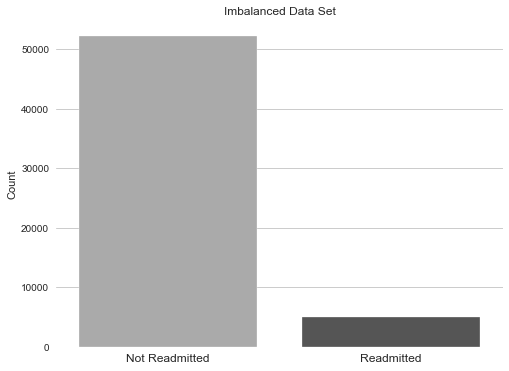

In [215]:
# Readmission before SMOTE

plt.figure(figsize=(8,6))
sns.countplot(y_train, palette='binary')
sns.despine()
sns.set_style('whitegrid')
plt.title('Imbalanced Data Set')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'], size = 12)
plt.xlabel('')
plt.ylabel('Count')
plt.show()

In [216]:
# SMOTE 

sm = SMOTE(random_state=123)
X_train_smo, y_train_smo = sm.fit_sample(X_train, y_train)


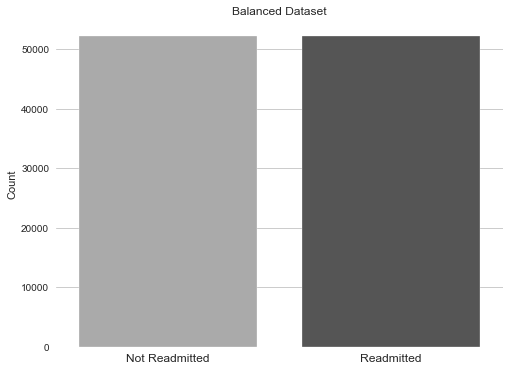

In [217]:
# Readmission After SMOTE

plt.figure(figsize=(8,6))
sns.countplot(y_train_smo, palette='binary')
sns.despine()
sns.set_style('whitegrid')
plt.title('Balanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'], size = 12)
plt.xlabel('')
plt.ylabel('Count')
plt.show()

# Modeling

In [218]:
# Define functions to aid in model evaluation

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [219]:
# Set threshold

thresh = 0.7

### Modeling: Logistic regression

In [220]:
# logistic Regression

lr = LogisticRegression(tol=1e-7, penalty='l2', C=0.0005, random_state = 123)
lr = lr.fit(X_train_smo, y_train_smo)
ylr = lr.predict(X_test)

In [221]:
# Assessing Model Performance

y_train_preds = lr.predict_proba(X_train_smo)[:,1]
y_valid_preds = lr.predict_proba(X_test)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train_smo,y_train_preds, thresh)
print('Test:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_test,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.934
accuracy:0.789
recall:0.579
precision:0.999
specificity:0.999
prevalence:0.500
 
Test:
AUC:0.545
accuracy:0.912
recall:0.003
precision:0.308
specificity:0.999
prevalence:0.088
 


In [222]:
# Classification Report

print(classification_report(y_test, ylr, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.91      0.91      0.91     13044
         YES       0.10      0.10      0.10      1259

    accuracy                           0.84     14303
   macro avg       0.51      0.51      0.51     14303
weighted avg       0.84      0.84      0.84     14303



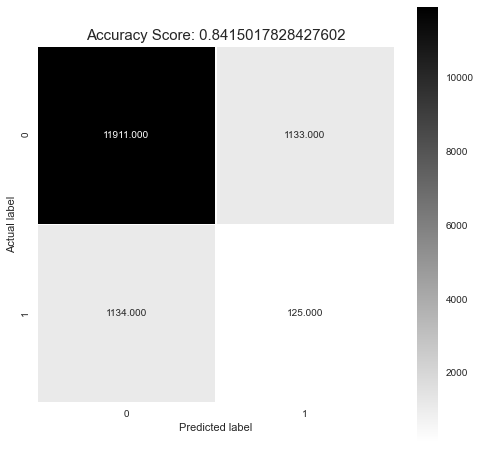

In [223]:
# Graphical confusion matrix

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, ylr), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'gray_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(lr.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

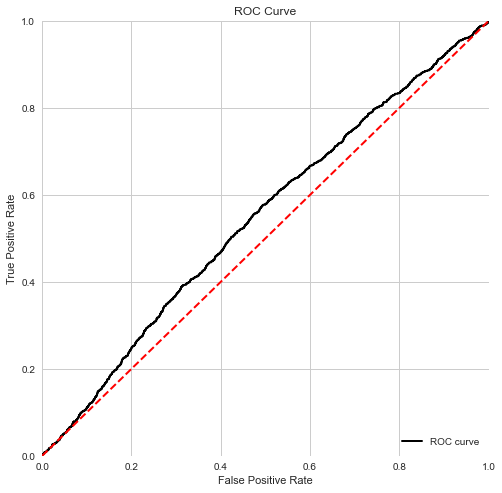

In [224]:
# ROC Curve

probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, color = 'black', lw = 2, label = 'ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], color='red', lw = 2, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [225]:
# Decile Analysis

readmit_proba = [i[1] for i in lr.predict_proba(X_test)]
quant = pd.qcut(readmit_proba,10,labels=np.arange(1,11))
prob = {'Quantile':quant,'# Readmitted':readmit_proba,'y':y_test}

decile = pd.DataFrame(prob).sort_values('Quantile')
dec1 = decile.groupby('Quantile')['# Readmitted'].agg(['count','min','max','mean']).reset_index()
dec2 = decile.groupby(['Quantile','y']).count().reset_index()
dec2 = dec2[dec2['y']==1]
decile = pd.merge(dec2, dec1, how='inner',on ='Quantile').drop('y',1).\
        rename({'count':'Unique Patients', 'min':'Min Prob', 'mean':'Average Prob','max':'Max Prob'},axis=1)

decile = decile[decile.columns[[0,2,1,3,4,5]]]
decile['Percent Readmitted'] = decile['# Readmitted']/decile['Unique Patients']
decile['Lift'] = decile['Percent Readmitted'].apply(lambda x:10*x/decile['Percent Readmitted'].sum())
decile.style.hide_index()

Quantile,Unique Patients,# Readmitted,Min Prob,Max Prob,Average Prob,Percent Readmitted,Lift
1,1431,103,0.007428,0.143271,0.109594,0.071978,0.817696
2,1430,106,0.143276,0.185313,0.165274,0.074126,0.842101
3,1430,107,0.185318,0.218110,0.202412,0.074825,0.850046
4,1430,111,0.218137,0.251644,0.234972,0.077622,0.881823
5,1431,109,0.251644,0.286455,0.269066,0.076171,0.865329
6,1430,140,0.286521,0.325168,0.305452,0.097902,1.112209
7,1430,125,0.325171,0.367286,0.345290,0.087413,0.993044
8,1430,155,0.367301,0.421597,0.393533,0.108392,1.231374
9,1430,166,0.421601,0.488242,0.452374,0.116084,1.318762
10,1431,137,0.488278,0.756967,0.558806,0.095737,1.087615


In [226]:
# Comparison between random sampling and the top 2 quantiles for readmission percentage

tot_compdic = {'Unique Patients': [decile['Unique Patients'].sum(), decile['Unique Patients'][8] + decile['Unique Patients'][9]], 
               '# Readmitted': [decile['# Readmitted'].sum(), decile['# Readmitted'][8] + decile['# Readmitted'][9]]}

tot_compdic['Percent Readmitted'] = [tot_compdic['# Readmitted'][0]/tot_compdic['Unique Patients'][0],
                                     tot_compdic['# Readmitted'][1]/tot_compdic['Unique Patients'][1]]

tot_compdic['Lift'] = ['NA', 10*tot_compdic['Percent Readmitted'][1]/decile['Percent Readmitted'].sum()]

tot_compdf = pd.DataFrame(tot_compdic, index = ['Random Sampling','Top 2 Quantiles'])
tot_compdf

,Unique Patients,# Readmitted,Percent Readmitted,Lift
Random Sampling,14303,1259,0.088023,NA
Top 2 Quantiles,2861,303,0.105907,1.20315


Text(0, 0.5, 'Feature')

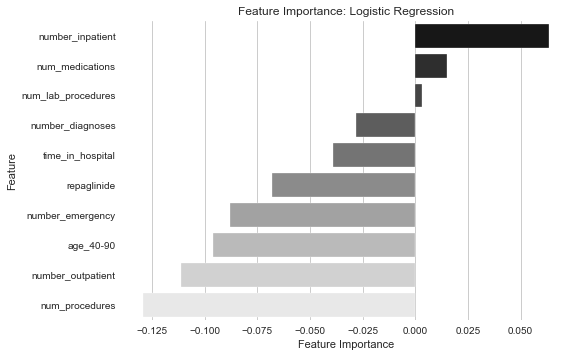

In [227]:
# Graphing Feature Importance

lr_feat_dict = {'Feature':X_train_smo.columns, 'Feature Importance':lr.coef_.reshape(lr.coef_.shape[1],)}
lr_feat_df = pd.DataFrame(lr_feat_dict)
lr_feat_df = lr_feat_df.sort_values('Feature Importance', ascending=False).head(10)
lr_feat_df

plt.figure()
sns.barplot(x = lr_feat_df['Feature Importance'], y = lr_feat_df['Feature'], palette = 'binary_r')
sns.set_style('whitegrid')
plt.title('Feature Importance: Logistic Regression')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

### Modeling: Logistic Regression CV

In [228]:
# logistic Regression CV

lr_cv=LogisticRegressionCV(tol=1e-7, penalty='l2', random_state = 123)
lr_cv.fit(X_train_smo, y_train_smo)
ylr_cv = lr_cv.predict(X_test)

In [229]:
# Assessing Model Performance

y_train_preds = lr_cv.predict_proba(X_train_smo)[:,1]
y_valid_preds = lr_cv.predict_proba(X_test)[:,1]

print('Logistic Regression CV')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train_smo,y_train_preds, thresh)
print('Test:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_test,y_valid_preds, thresh)

Logistic Regression CV
Training:
AUC:0.950
accuracy:0.918
recall:0.835
precision:1.000
specificity:1.000
prevalence:0.500
 
Test:
AUC:0.565
accuracy:0.912
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.088
 


In [230]:
# Checking the Summary of Classification

print(classification_report(y_test, ylr_cv, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.91      1.00      0.95     13044
         YES       0.20      0.00      0.01      1259

    accuracy                           0.91     14303
   macro avg       0.56      0.50      0.48     14303
weighted avg       0.85      0.91      0.87     14303



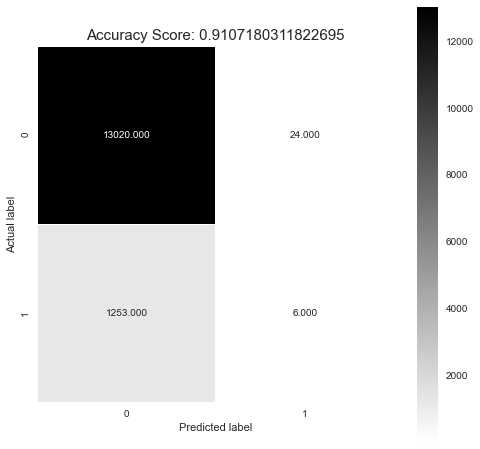

In [231]:
# Graphical Confusion Matrix

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, ylr_cv), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'gray_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(lr_cv.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

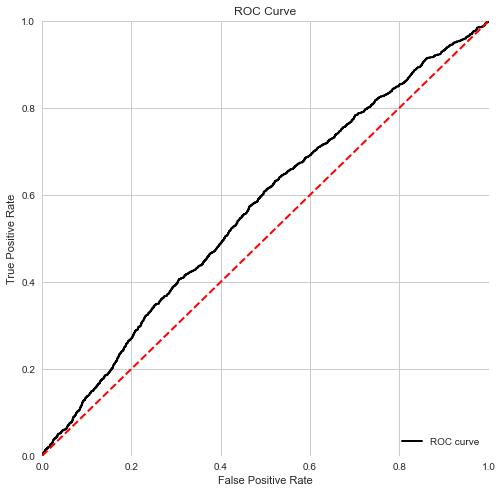

In [232]:
# ROC Curve

probs = lr_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, color = 'black', lw = 2, label = 'ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], color='red', lw = 2, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [233]:
# Decile Analysis

readmit_proba = [i[1] for i in lr_cv.predict_proba(X_test)]
quant = pd.qcut(readmit_proba,10,labels=np.arange(1,11))
prob = {'Quantile':quant,'# Readmitted':readmit_proba,'y':y_test}

decile = pd.DataFrame(prob).sort_values('Quantile')
dec1 = decile.groupby('Quantile')['# Readmitted'].agg(['count','min','max','mean']).reset_index()
dec2 = decile.groupby(['Quantile','y']).count().reset_index()
dec2 = dec2[dec2['y']==1]
decile = pd.merge(dec2, dec1, how='inner',on ='Quantile').drop('y',1).\
        rename({'count':'Unique Patients', 'min':'Min Prob', 'mean':'Average Prob','max':'Max Prob'},axis=1)

decile = decile[decile.columns[[0,2,1,3,4,5]]]
decile['Percent Readmitted'] = decile['# Readmitted']/decile['Unique Patients']
decile['Lift'] = decile['Percent Readmitted'].apply(lambda x:10*x/decile['Percent Readmitted'].sum())
decile.style.hide_index()

Quantile,Unique Patients,# Readmitted,Min Prob,Max Prob,Average Prob,Percent Readmitted,Lift
1,1431,87,0.005445,0.045574,0.033374,0.060797,0.690682
2,1430,103,0.045576,0.063257,0.054809,0.072028,0.818276
3,1430,99,0.063261,0.078673,0.070903,0.069231,0.786499
4,1430,106,0.078673,0.095233,0.086794,0.074126,0.842110
5,1431,113,0.095238,0.113511,0.104193,0.078966,0.897093
6,1430,147,0.113514,0.135704,0.123974,0.102797,1.167831
7,1430,117,0.135718,0.162023,0.148098,0.081818,0.929498
8,1430,154,0.162077,0.198626,0.179108,0.107692,1.223442
9,1430,166,0.198651,0.261058,0.226448,0.116084,1.318775
10,1431,167,0.261180,0.622372,0.331230,0.116702,1.325793


In [234]:
# Comparison between random sampling and the top 2 quantiles for readmission percentage

tot_compdic = {'Unique Patients': [decile['Unique Patients'].sum(), decile['Unique Patients'][8] + decile['Unique Patients'][9]], 
               '# Readmitted': [decile['# Readmitted'].sum(), decile['# Readmitted'][8] + decile['# Readmitted'][9]]}

tot_compdic['Percent Readmitted'] = [tot_compdic['# Readmitted'][0]/tot_compdic['Unique Patients'][0],
                                     tot_compdic['# Readmitted'][1]/tot_compdic['Unique Patients'][1]]

tot_compdic['Lift'] = ['NA', 10*tot_compdic['Percent Readmitted'][1]/decile['Percent Readmitted'].sum()]

tot_compdf = pd.DataFrame(tot_compdic, index = ['Random Sampling','Top 2 Quantiles'])
tot_compdf

,Unique Patients,# Readmitted,Percent Readmitted,Lift
Random Sampling,14303,1259,0.088023,NA
Top 2 Quantiles,2861,333,0.116393,1.32229


Text(0, 0.5, 'Feature')

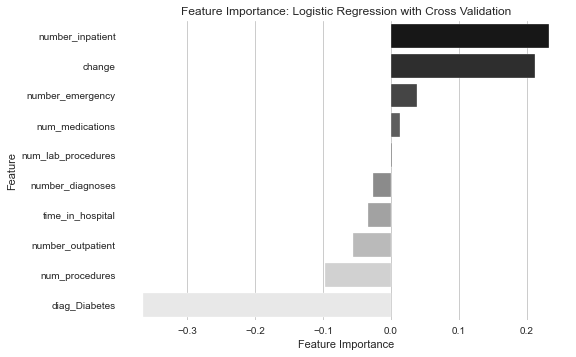

In [235]:
# Graphing Feature Importance

lrcv_feat_dict = {'Feature':X_train.columns, 'Feature Importance':lr_cv.coef_.reshape(lr_cv.coef_.shape[1],)}
lrcv_feat_df = pd.DataFrame(lrcv_feat_dict)
lrcv_feat_df = lrcv_feat_df.sort_values('Feature Importance', ascending=False).head(10)

plt.figure()
sns.barplot(x = lrcv_feat_df['Feature Importance'], y = lrcv_feat_df['Feature'], palette = 'binary_r')
sns.set_style('whitegrid')
plt.title('Feature Importance: Logistic Regression with Cross Validation')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

### Modeling: Random Forest

In [236]:
# Random Forest Classifier

random_forest = RandomForestClassifier(random_state=123,n_estimators=500)
random_forest.fit(X_train_smo, y_train_smo)
Yrandforest = random_forest.predict(X_test)

In [237]:
# Assessing Model Performance

y_train_preds = random_forest.predict_proba(X_train_smo)[:,1]
y_test_preds = random_forest.predict_proba(X_test)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train_smo,y_train_preds, thresh)
print('Test:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_test,y_test_preds, thresh)

Random Forest
Training:
AUC:1.000
accuracy:0.979
recall:0.958
precision:1.000
specificity:1.000
prevalence:0.500
 
Test:
AUC:0.563
accuracy:0.910
recall:0.000
precision:0.000
specificity:0.998
prevalence:0.088
 


In [238]:
# Checking the Summary of Classification

print(classification_report(y_test, Yrandforest, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.91      0.99      0.95     13044
         YES       0.10      0.01      0.02      1259

    accuracy                           0.90     14303
   macro avg       0.50      0.50      0.49     14303
weighted avg       0.84      0.90      0.87     14303



Text(0.5, 1.0, 'Accuracy Score: 0.9032370831294134')

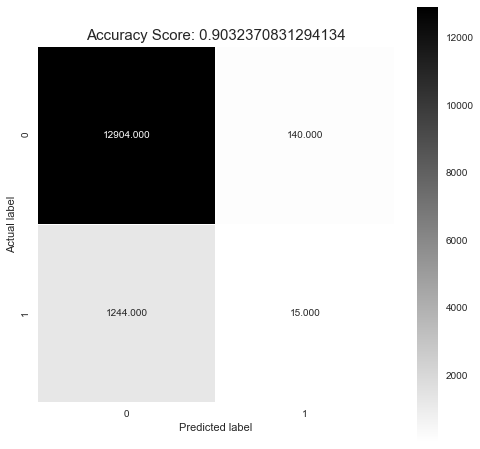

In [239]:
# Graphical Confusion Matrix

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, Yrandforest), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'gray_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(random_forest.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

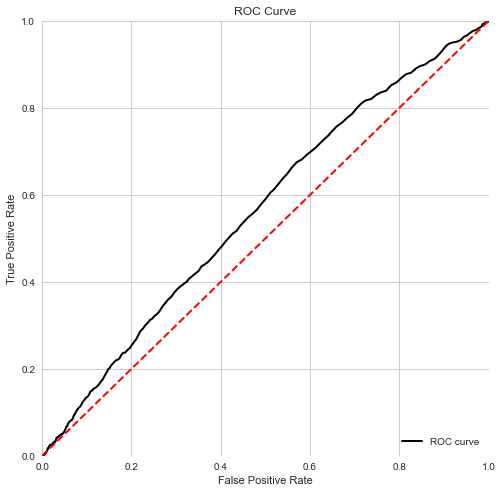

In [240]:
# ROC Curve

probs = random_forest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, color = 'black', lw = 2, label = 'ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], color='red', lw = 2, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [241]:
# Decile Analysis

readmit_proba = [i[1] for i in random_forest.predict_proba(X_test)]
quant = pd.qcut(readmit_proba,10,labels=np.arange(1,11))
prob = {'Quantile':quant,'# Readmitted':readmit_proba,'y':y_test}

decile = pd.DataFrame(prob).sort_values('Quantile')
dec1 = decile.groupby('Quantile')['# Readmitted'].agg(['count','min','max','mean']).reset_index()
dec2 = decile.groupby(['Quantile','y']).count().reset_index()
dec2 = dec2[dec2['y']==1]
decile = pd.merge(dec2, dec1, how='inner',on ='Quantile').drop('y',1).\
        rename({'count':'Unique Patients', 'min':'Min Prob', 'mean':'Average Prob','max':'Max Prob'},axis=1)

decile = decile[decile.columns[[0,2,1,3,4,5]]]
decile['Percent Readmitted'] = decile['# Readmitted']/decile['Unique Patients']
decile['Lift'] = decile['Percent Readmitted'].apply(lambda x:10*x/decile['Percent Readmitted'].sum())
decile.style.hide_index()

Quantile,Unique Patients,# Readmitted,Min Prob,Max Prob,Average Prob,Percent Readmitted,Lift
1,1448,87,0.000000,0.040000,0.026339,0.060083,0.679980
2,1419,91,0.041000,0.060000,0.051324,0.064130,0.725779
3,1554,103,0.062000,0.080000,0.070932,0.066281,0.750121
4,1440,120,0.080667,0.100000,0.090938,0.083333,0.943114
5,1321,130,0.102000,0.118000,0.109789,0.098410,1.113745
6,1490,145,0.120000,0.142000,0.130508,0.097315,1.101354
7,1402,123,0.144000,0.170000,0.156635,0.087732,0.992893
8,1437,154,0.172000,0.206000,0.188098,0.107168,1.212856
9,1390,144,0.208000,0.270000,0.234970,0.103597,1.172446
10,1402,162,0.271000,0.918000,0.369543,0.115549,1.307712


In [242]:
# Comparison between random sampling and the top 2 quantiles for readmission percentage

tot_compdic = {'Unique Patients': [decile['Unique Patients'].sum(), decile['Unique Patients'][8] + decile['Unique Patients'][9]], 
               '# Readmitted': [decile['# Readmitted'].sum(), decile['# Readmitted'][8] + decile['# Readmitted'][9]]}

tot_compdic['Percent Readmitted'] = [tot_compdic['# Readmitted'][0]/tot_compdic['Unique Patients'][0],
                                     tot_compdic['# Readmitted'][1]/tot_compdic['Unique Patients'][1]]

tot_compdic['Lift'] = ['NA', 10*tot_compdic['Percent Readmitted'][1]/decile['Percent Readmitted'].sum()]

tot_compdf = pd.DataFrame(tot_compdic, index = ['Random Sampling','Top 2 Quantiles'])
tot_compdf

,Unique Patients,# Readmitted,Percent Readmitted,Lift
Random Sampling,14303,1259,0.088023,NA
Top 2 Quantiles,2792,306,0.109599,1.24037


Text(0, 0.5, 'Feature')

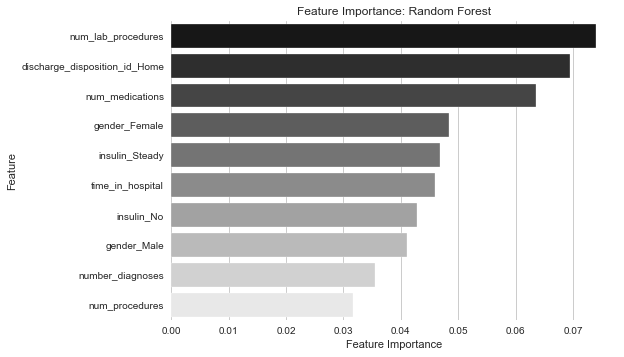

In [243]:
#Determining which features are most important,
feature_names = X_train_smo.columns
feature_imports = random_forest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True, ascending= False)

plt.figure()
sns.barplot(x = most_imp_features['Importance'], y = most_imp_features['Feature'], palette = 'binary_r')
sns.set_style('whitegrid')
plt.title('Feature Importance: Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

### Modeling: XGBoost Classifier 

In [244]:
# XG Boost Classifier

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, random_state=123)
xgb_clf.fit(X_train_smo, y_train_smo)
Yxgb = xgb_clf.predict(X_test)

[23:13:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [245]:
# Assessing Model Performance

y_train_preds = xgb_clf.predict_proba(X_train_smo)[:,1]
y_test_preds = xgb_clf.predict_proba(X_test)[:,1]

print('XGBoost')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train_smo,y_train_preds, thresh)
print('Test:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_test,y_test_preds, thresh)

XGBoost
Training:
AUC:0.952
accuracy:0.875
recall:0.751
precision:1.000
specificity:1.000
prevalence:0.500
 
Test:
AUC:0.568
accuracy:0.912
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.088
 


Text(0.5, 1.0, 'Accuracy Score: 0.8858980633433545')

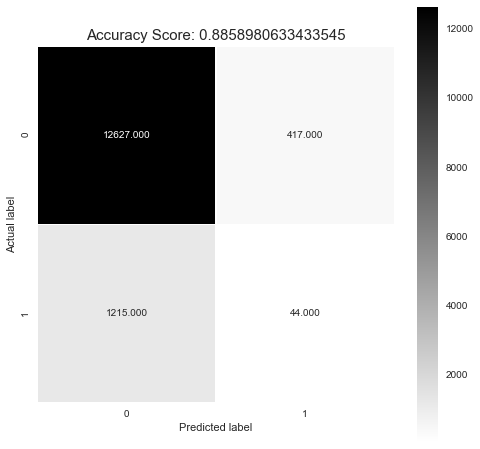

In [246]:
# Graphical Confusion Matrix

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, Yxgb), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'gray_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(xgb_clf.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

In [247]:
# Checking the Summary of Classification

print(classification_report(y_test, Yxgb, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.91      0.97      0.94     13044
         YES       0.10      0.03      0.05      1259

    accuracy                           0.89     14303
   macro avg       0.50      0.50      0.50     14303
weighted avg       0.84      0.89      0.86     14303



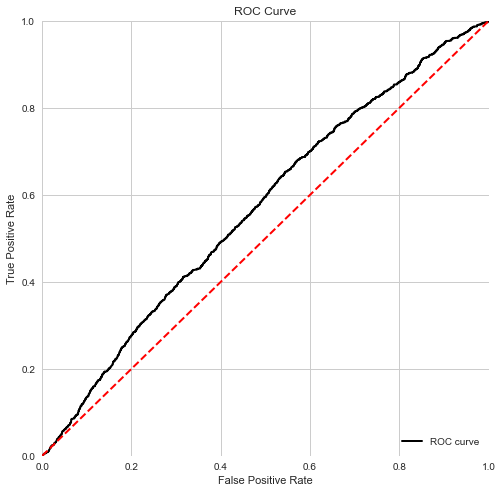

In [248]:
# ROC Curve

probs = xgb_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, color = 'black', lw = 2, label = 'ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], color='red', lw = 2, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [249]:
# Decile Analysis

readmit_proba = [i[1] for i in xgb_clf.predict_proba(X_test)]
quant = pd.qcut(readmit_proba,10,labels=np.arange(1,11))
prob = {'Quantile':quant,'# Readmitted':readmit_proba,'y':y_test}

decile = pd.DataFrame(prob).sort_values('Quantile')
dec1 = decile.groupby('Quantile')['# Readmitted'].agg(['count','min','max','mean']).reset_index()
dec2 = decile.groupby(['Quantile','y']).count().reset_index()
dec2 = dec2[dec2['y']==1]
decile = pd.merge(dec2, dec1, how='inner',on ='Quantile').drop('y',1).\
        rename({'count':'Unique Patients', 'min':'Min Prob', 'mean':'Average Prob','max':'Max Prob'},axis=1)

decile = decile[decile.columns[[0,2,1,3,4,5]]]
decile['Percent Readmitted'] = decile['# Readmitted']/decile['Unique Patients']
decile['Lift'] = decile['Percent Readmitted'].apply(lambda x:10*x/decile['Percent Readmitted'].sum())
decile.style.hide_index()

Quantile,Unique Patients,# Readmitted,Min Prob,Max Prob,Average Prob,Percent Readmitted,Lift
1,1431,69,0.039530,0.101772,0.084462,0.048218,0.547604
2,1430,114,0.101786,0.125053,0.114213,0.079720,0.905370
3,1430,93,0.125058,0.146565,0.135781,0.065035,0.738591
4,1430,112,0.146581,0.168628,0.157259,0.078322,0.889486
5,1437,135,0.168643,0.193757,0.181140,0.093946,1.066926
6,1425,128,0.193759,0.224737,0.208803,0.089825,1.020122
7,1429,129,0.224748,0.264777,0.243218,0.090273,1.025214
8,1451,145,0.264781,0.313983,0.287567,0.099931,1.134900
9,1409,170,0.314112,0.391151,0.348420,0.120653,1.370235
10,1431,164,0.391184,0.672034,0.474467,0.114605,1.301552


In [250]:
# Comparison between random sampling and the top 2 quantiles for readmission percentage

tot_compdic = {'Unique Patients': [decile['Unique Patients'].sum(), decile['Unique Patients'][8] + decile['Unique Patients'][9]], 
               '# Readmitted': [decile['# Readmitted'].sum(), decile['# Readmitted'][8] + decile['# Readmitted'][9]]}

tot_compdic['Percent Readmitted'] = [tot_compdic['# Readmitted'][0]/tot_compdic['Unique Patients'][0],
                                     tot_compdic['# Readmitted'][1]/tot_compdic['Unique Patients'][1]]

tot_compdic['Lift'] = ['NA', 10*tot_compdic['Percent Readmitted'][1]/decile['Percent Readmitted'].sum()]

tot_compdf = pd.DataFrame(tot_compdic, index = ['Random Sampling','Top 2 Quantiles'])
tot_compdf

,Unique Patients,# Readmitted,Percent Readmitted,Lift
Random Sampling,14303,1259,0.088023,NA
Top 2 Quantiles,2840,334,0.117606,1.33563


Text(0, 0.5, 'Feature')

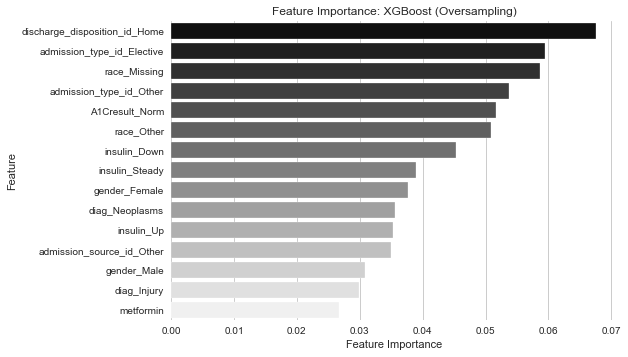

In [251]:
# Graphing the Most Important Features

feature_names = X_train_smo.columns
feature_imports = xgb_clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(15, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True, ascending= False)

plt.figure()
sns.barplot(x = most_imp_features['Importance'], y = most_imp_features['Feature'], palette = 'binary_r')
sns.set_style('whitegrid')
plt.title('Feature Importance: XGBoost (Oversampling)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

# Balancing: Undersampling

In [252]:
# Combine training

X_down = pd.concat([X_train, y_train], axis=1)

# Separate Minority and Majority

not_readmitted = X_down[X_down.readmitted==0]
readmitted = X_down[X_down.readmitted==1]

# Downsample Majority Class

not_readmit_downsampled = resample(not_readmitted,
                                     replace = False, # sample without replacement
                                     n_samples = int(1*len(readmitted)), # match minority n
                                     random_state = 1) # reproducible results

# Combine Minority and Downsampled Majority

downsampled = pd.concat([not_readmit_downsampled, readmitted])

# Check counts

print(downsampled.readmitted.value_counts())

y_train_down = downsampled['readmitted']
x_train_down = downsampled.drop('readmitted',1)

1    5034
0    5034
Name: readmitted, dtype: int64


# Final Model

### XGBoost (Undersampled)

In [253]:
# Different objective parameter set seems to increase accuracy & percsion with minimal AUC loss

xgb_clf2 = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=123, eta=0.1 , eval_metric=auc)
xgb_clf2.fit(x_train_down, y_train_down)
Yxgb2 = xgb_clf.predict(X_test)

[23:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [254]:
# Assessing Model Performance

y_train_preds = xgb_clf2.predict_proba(x_train_down)[:,1]
y_test_preds = xgb_clf2.predict_proba(X_test)[:,1]

print('XGBoost')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train_down,y_train_preds, thresh)
print('Test:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_test,y_test_preds, thresh)

XGBoost
Training:
AUC:0.808
accuracy:0.590
recall:0.187
precision:0.959
specificity:0.992
prevalence:0.500
 
Test:
AUC:0.612
accuracy:0.872
recall:0.115
precision:0.169
specificity:0.945
prevalence:0.088
 


In [255]:
# Checking the Summary of Classification

print(classification_report(y_test, Yxgb2, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.91      0.97      0.94     13044
         YES       0.10      0.03      0.05      1259

    accuracy                           0.89     14303
   macro avg       0.50      0.50      0.50     14303
weighted avg       0.84      0.89      0.86     14303



Text(0.5, 1.0, 'Accuracy Score: 0.5988953366426624')

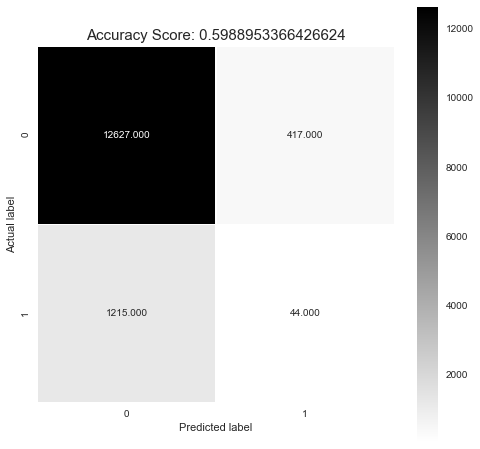

In [256]:
# Graphical Confusion Matrix

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, Yxgb2), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'gray_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(xgb_clf2.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

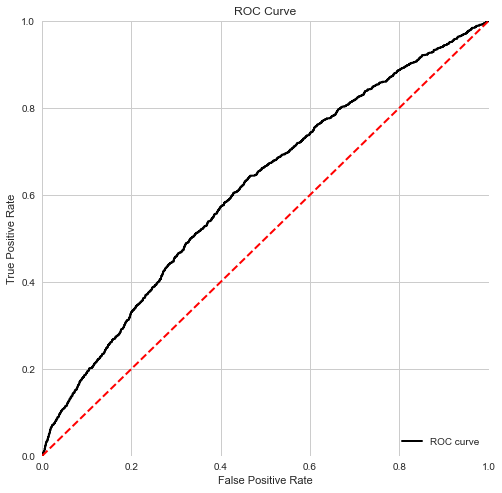

In [257]:
# ROC Curve

probs = xgb_clf2.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, color = 'black', lw = 2, label = 'ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], color='red', lw = 2, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [258]:
# Decile Analysis

readmit_proba = [i[1] for i in xgb_clf2.predict_proba(X_test)]
quant = pd.qcut(readmit_proba,10,labels=np.arange(1,11))
prob = {'Quantile':quant,'# Readmitted':readmit_proba,'y':y_test}

decile = pd.DataFrame(prob).sort_values('Quantile')
dec1 = decile.groupby('Quantile')['# Readmitted'].agg(['count','min','max','mean']).reset_index()
dec2 = decile.groupby(['Quantile','y']).count().reset_index()
dec2 = dec2[dec2['y']==1]
decile = pd.merge(dec2, dec1, how='inner',on ='Quantile').drop('y',1).\
        rename({'count':'Unique Patients', 'min':'Min Prob', 'mean':'Average Prob','max':'Max Prob'},axis=1)

decile = decile[decile.columns[[0,2,1,3,4,5]]]
decile['Percent Readmitted'] = decile['# Readmitted']/decile['Unique Patients']
decile['Lift'] = decile['Percent Readmitted'].apply(lambda x:10*x/decile['Percent Readmitted'].sum())
decile.style.hide_index()

Quantile,Unique Patients,# Readmitted,Min Prob,Max Prob,Average Prob,Percent Readmitted,Lift
1,1431,75,0.056347,0.314022,0.259760,0.052411,0.595426
2,1430,76,0.314026,0.362648,0.341074,0.053147,0.603787
3,1430,86,0.362651,0.394911,0.379262,0.060140,0.683232
4,1430,103,0.394944,0.425795,0.409482,0.072028,0.818290
5,1431,95,0.425796,0.462820,0.443716,0.066387,0.754206
6,1430,128,0.462839,0.506058,0.483907,0.089510,1.016904
7,1430,139,0.506066,0.550746,0.528558,0.097203,1.104294
8,1430,167,0.550765,0.595277,0.572273,0.116783,1.326742
9,1430,163,0.595284,0.659756,0.624838,0.113986,1.294964
10,1431,227,0.659772,0.955043,0.729307,0.158630,1.802155


In [259]:
# Comparison between random sampling and the top 2 quantiles for readmission percentage

tot_compdic = {'Unique Patients': [decile['Unique Patients'].sum(), decile['Unique Patients'][8] + decile['Unique Patients'][9]], 
               '# Readmitted': [decile['# Readmitted'].sum(), decile['# Readmitted'][8] + decile['# Readmitted'][9]]}

tot_compdic['Percent Readmitted'] = [tot_compdic['# Readmitted'][0]/tot_compdic['Unique Patients'][0],
                                     tot_compdic['# Readmitted'][1]/tot_compdic['Unique Patients'][1]]

tot_compdic['Lift'] = ['NA', 10*tot_compdic['Percent Readmitted'][1]/decile['Percent Readmitted'].sum()]

tot_compdf = pd.DataFrame(tot_compdic, index = ['Random Sampling','Top 2 Quantiles'])
tot_compdf

,Unique Patients,# Readmitted,Percent Readmitted,Lift
Random Sampling,14303,1259,0.088023,NA
Top 2 Quantiles,2861,390,0.136316,1.54865


Text(0, 0.5, 'Feature')

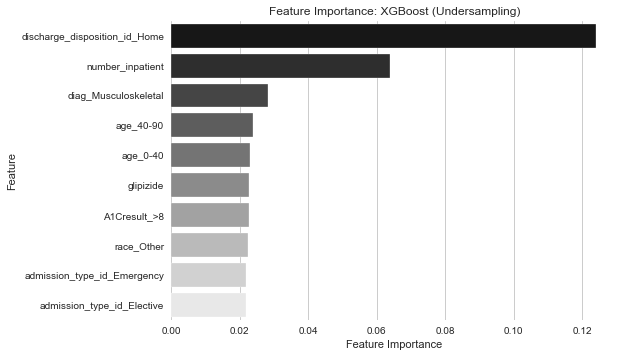

In [260]:
# Graphing the Most Important Features

feature_names = x_train_down.columns
feature_imports = xgb_clf2.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True, ascending= False)

plt.figure()
sns.barplot(x = most_imp_features['Importance'], y = most_imp_features['Feature'], palette = 'binary_r')
sns.set_style('whitegrid')
plt.title('Feature Importance: XGBoost (Undersampling)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

<p><a name="xgbcv"></a></p>

## XGBoost Hyperparameter Tuning

In [261]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

In [262]:
eta = np.arange(0.05,0.35,0.05)
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
gamma = [i/10 for i in range(0,5)]

params_xgb = {'eta':eta, 'max_depth':max_depth, 
              'min_child_weight':min_child_weight,
              'gamma':gamma}

xgb_grid = xgb.XGBClassifier()

xgb_clf = GridSearchCV(xgb_grid, param_grid=params_xgb, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)

xgb_clf.fit(x_train_down,y_train_down)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  9.8min finished


[23:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...e,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, 

In [263]:
xgb_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0.3,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# XGBoost with tuned Parameters 

In [264]:
# Different objective parameter set seems to increase accuracy & percsion with minimal AUC loss

xgb_clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0.3,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_clf2.fit(x_train_down, y_train_down)
Yxgb2 = xgb_clf.predict(X_test)

[23:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [265]:
# Assessing Model Performance

y_train_preds = xgb_clf2.predict_proba(x_train_down)[:,1]
y_test_preds = xgb_clf2.predict_proba(X_test)[:,1]

print('XGBoost')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train_down,y_train_preds, thresh)
print('Test:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_test,y_test_preds, thresh)

XGBoost
Training:
AUC:0.656
accuracy:0.526
recall:0.066
precision:0.830
specificity:0.986
prevalence:0.500
 
Test:
AUC:0.624
accuracy:0.900
recall:0.056
precision:0.225
specificity:0.981
prevalence:0.088
 


In [266]:
# Checking the Summary of Classification

print(classification_report(y_test, Yxgb2, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.94      0.57      0.71     13044
         YES       0.12      0.61      0.20      1259

    accuracy                           0.57     14303
   macro avg       0.53      0.59      0.46     14303
weighted avg       0.87      0.57      0.66     14303



Text(0.5, 1.0, 'Accuracy Score: 0.572816891561211')

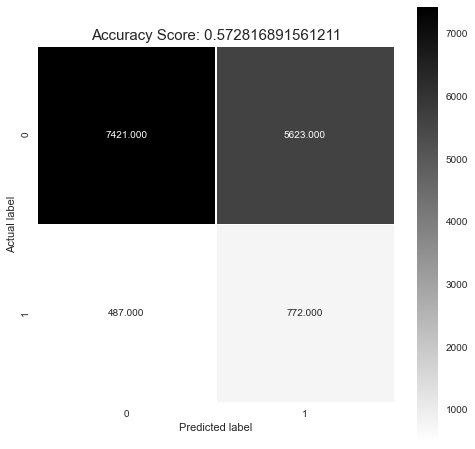

In [267]:
# Graphical Confusion Matrix

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, Yxgb2), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'gray_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(xgb_clf2.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

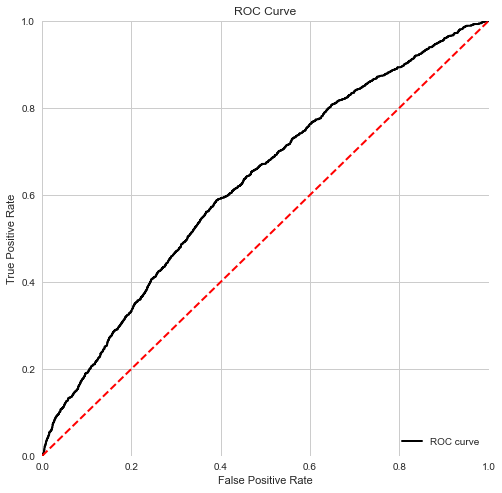

In [268]:
# ROC Curve

probs = xgb_clf2.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, color = 'black', lw = 2, label = 'ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], color='red', lw = 2, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [269]:
# Decile Analysis

readmit_proba = [i[1] for i in xgb_clf2.predict_proba(X_test)]
quant = pd.qcut(readmit_proba,10,labels=np.arange(1,11))
prob = {'Quantile':quant,'# Readmitted':readmit_proba,'y':y_test}

decile = pd.DataFrame(prob).sort_values('Quantile')
dec1 = decile.groupby('Quantile')['# Readmitted'].agg(['count','min','max','mean']).reset_index()
dec2 = decile.groupby(['Quantile','y']).count().reset_index()
dec2 = dec2[dec2['y']==1]
decile = pd.merge(dec2, dec1, how='inner',on ='Quantile').drop('y',1).\
        rename({'count':'Unique Patients', 'min':'Min Prob', 'mean':'Average Prob','max':'Max Prob'},axis=1)

decile = decile[decile.columns[[0,2,1,3,4,5]]]
decile['Percent Readmitted'] = decile['# Readmitted']/decile['Unique Patients']
decile['Lift'] = decile['Percent Readmitted'].apply(lambda x:10*x/decile['Percent Readmitted'].sum())
decile.style.hide_index()

Quantile,Unique Patients,# Readmitted,Min Prob,Max Prob,Average Prob,Percent Readmitted,Lift
1,1431,58,0.241479,0.365029,0.343560,0.040531,0.460460
2,1430,81,0.365038,0.386846,0.376334,0.056643,0.643506
3,1430,77,0.386852,0.406389,0.396866,0.053846,0.611728
4,1430,103,0.406417,0.426936,0.416381,0.072028,0.818286
5,1431,105,0.426956,0.474383,0.445432,0.073375,0.833592
6,1430,111,0.474402,0.517137,0.498262,0.077622,0.881842
7,1430,154,0.517161,0.543998,0.531540,0.107692,1.223456
8,1430,166,0.544045,0.571124,0.556799,0.116084,1.318791
9,1430,179,0.571137,0.612745,0.590919,0.125175,1.422070
10,1431,225,0.612746,0.843574,0.663914,0.157233,1.786268


In [270]:
# Comparison between random sampling and the top 2 quantiles for readmission percentage

tot_compdic = {'Unique Patients': [decile['Unique Patients'].sum(), decile['Unique Patients'][8] + decile['Unique Patients'][9]], 
               '# Readmitted': [decile['# Readmitted'].sum(), decile['# Readmitted'][8] + decile['# Readmitted'][9]]}

tot_compdic['Percent Readmitted'] = [tot_compdic['# Readmitted'][0]/tot_compdic['Unique Patients'][0],
                                     tot_compdic['# Readmitted'][1]/tot_compdic['Unique Patients'][1]]

tot_compdic['Lift'] = ['NA', 10*tot_compdic['Percent Readmitted'][1]/decile['Percent Readmitted'].sum()]

tot_compdf = pd.DataFrame(tot_compdic, index = ['Random Sampling','Top 2 Quantiles'])
tot_compdf

,Unique Patients,# Readmitted,Percent Readmitted,Lift
Random Sampling,14303,1259,0.088023,NA
Top 2 Quantiles,2861,404,0.141209,1.60423


([<matplotlib.axis.YTick at 0x1d63b86a700>,
 [Text(0, 0, 'Discharged to Home'),
  Text(0, 0, 'Number of Inpatient Visits'),
  Text(0, 0, 'Muskuloskeletal Disease'),
  Text(0, 0, 'Age 40-90'),
  Text(0, 0, 'Age Under 40'),
  Text(0, 0, 'Takes Glipizide'),
  Text(0, 0, 'A1C Over 8%')])

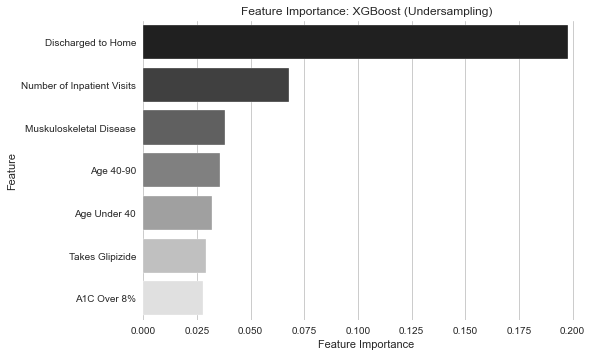

In [281]:
# Graphing the Most Important Features

feature_names = x_train_down.columns
feature_imports = xgb_clf2.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(7, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True, ascending= False)

plt.figure()
sns.barplot(x = most_imp_features['Importance'], y = most_imp_features['Feature'], palette = 'binary_r')
sns.set_style('whitegrid')
plt.title('Feature Importance: XGBoost (Undersampling)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.yticks(np.arange(7), ('Discharged to Home', 'Number of Inpatient Visits','Muskuloskeletal Disease','Age 40-90',
          'Age Under 40','Takes Glipizide','A1C Over 8%'))